In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image, UnidentifiedImageError
from dotenv import load_dotenv
import requests
from PIL import Image
from io import BytesIO
load_dotenv()

True

In [43]:
# Configuration
DEVICE = None
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA device found.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("MPS device found.")
else:
    DEVICE = torch.device("cpu")
    print("MPS/CUDA device not found, falling back to CPU.")

x = torch.ones(1, device=DEVICE)
print(x)
print(f"The available device is {DEVICE}")

CUDA device found.
tensor([1.], device='cuda:0')
The available device is cuda


In [54]:

# Fully Convolutional Architecture
class Encoder(nn.Module):
    def __init__(self, in_channel=3):
        super().__init__()
        # Input: 3 x 224 x 224
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 32, 3, stride=1, padding=1),  # -> 32 x 224 x 224
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),          # -> 64 x 224 x 224
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),         # -> 128 x 224 x 224
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),        # -> 256 x 224 x 224
            nn.ReLU(True),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),        # -> 512 x 224 x 224
            nn.ReLU(True),
            # Bottleneck convolution to compress channels
            # Output will be 32 x 224 x 224 (No downsampling)
            nn.Conv2d(512, 32, 3, padding=1),                   
            nn.ReLU(True)
        )

    def forward(self, x):
        z = self.conv(x)
        return z

class Decoder(nn.Module):
    def __init__(self, out_channel=3):
        super().__init__()
        
        self.deconv = nn.Sequential(
            # Expand channels back from 32 to 512
            nn.ConvTranspose2d(32, 512, 3, padding=1),          # -> 512 x 224 x 224
            nn.ReLU(True),
            # Upsampling path
            nn.ConvTranspose2d(512, 256, 3, stride=1, padding=1), # -> 256 x 224 x 224
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 3, stride=1, padding=1), # -> 128 x 224 x 224
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),  # -> 64 x 224 x 224
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),   # -> 32 x 224 x 224
            nn.ReLU(True),
            nn.ConvTranspose2d(32, out_channel, 3, stride=1, padding=1), # -> 3 x 224 x 224
            nn.Sigmoid()
        )

    def forward(self, z):
        out = self.deconv(z)
        return out

class AutoEncoder(nn.Module):
    def __init__(self, in_channel=3):
        super().__init__()
        self.encoder = Encoder(in_channel)
        self.decoder = Decoder(in_channel)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


In [55]:
model = AutoEncoder(in_channel=3).to(DEVICE)

In [46]:
ae_fcn_path = '/workspace/Neural_Nets/ae_checkpoints_fcn/ae_best_fcn.pt'

In [56]:
model.load_state_dict(torch.load(ae_fcn_path))

<All keys matched successfully>

In [57]:
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(512, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
  )
  (decoder): Decoder(
    (deconv): Sequential(
      (0): ConvTranspose2d(32, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)

In [49]:


# 1. Define the URL of the image you want to download
IMGURL = 'https://images.unsplash.com/photo-1558980394-da1f85d3b540?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEzMDkxNX0'
img_folder = './test_image_data'
try:
    # 2. Send an HTTP GET request to the URL
    response = requests.get(IMGURL)

    # 3. Check if the request was successful (status code 200)
    if response.status_code == 200:
        # 4. Use BytesIO to handle the image data in memory as a file-like object
        image_data = BytesIO(response.content)

        # 5. Open the image using Pillow's Image.open() method
        image = Image.open(image_data)

        # The 'image' variable is now a Pillow Image object, ready for manipulation

        # Optional: You can display the image or save it to your local disk
        # image.show() # Displays the image (requires an image viewer installed)
        image.save(f'{img_folder}/downloaded_image.jpg') # Saves the image to a file

        print(f"Successfully downloaded and opened image. Saved as 'downloaded_image.jpg'")
    else:
        print(f"Failed to retrieve image. Status code: {response.status_code}")

except requests.exceptions.RequestException as e:
    print(f"An error occurred during the request: {e}")
except IOError as e:
    print(f"An error occurred while opening the image with Pillow: {e}")



Successfully downloaded and opened image. Saved as 'downloaded_image.jpg'


In [50]:
# Data Loading
print("Loading data...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image = Image.open(f'{img_folder}/downloaded_image.jpg') # Saves the image to a file
tensor_image = transform(image).to(DEVICE)

Loading data...


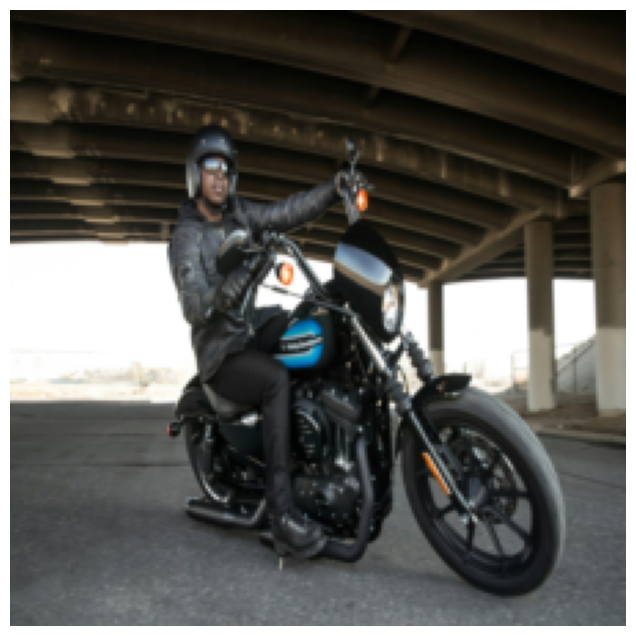

In [51]:
orig = tensor_image.cpu().mul(255).byte().permute(1, 2, 0).numpy()
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(orig)
plt.show()
plt.close()

In [60]:
recon, _ = model(tensor_image)

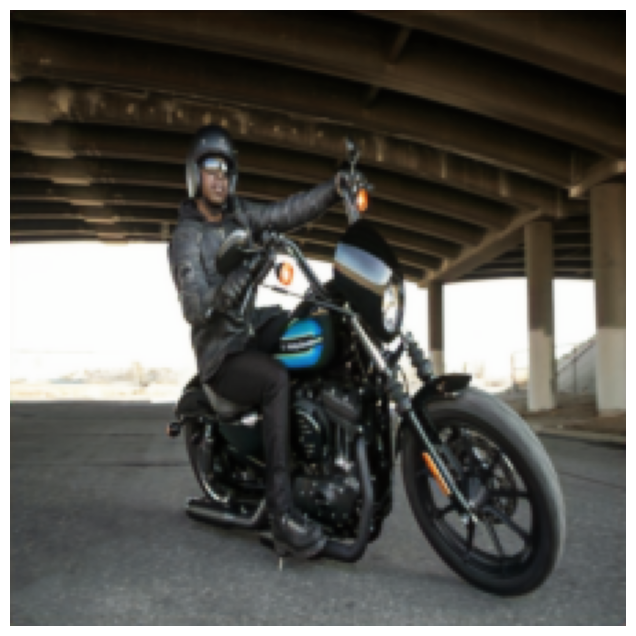

In [61]:
recon = recon.cpu().mul(255).byte().permute(1, 2, 0).numpy()
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(recon)
plt.show()
plt.close()